In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [29]:
digits = load_digits()
X, y = digits.data, digits.target

# формат PyTorch
X = X.reshape(-1, 8, 8) / 16.0
X = X.reshape(-1, 1, 8, 8)

X = torch.FloatTensor(X)
y = torch.LongTensor(y)

print(f"Размерность данных: {X.shape}")
print(f"Размерность меток: {y.shape}")
print(f"Количество классов: {len(torch.unique(y))}")

Размерность данных: torch.Size([1797, 1, 8, 8])
Размерность меток: torch.Size([1797])
Количество классов: 10


In [30]:
# 60 - 20 - 20
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# train_mean = X_train.mean()
# train_std = X_train.std()
# X_train = (X_train - train_mean) / train_std
# X_val = (X_val - train_mean) / train_std
# X_test = (X_test - train_mean) / train_std

batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
train_loader_normalized = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader_normalized = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader_normalized = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_val)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 1149
Размер валидационной выборки: 288
Размер тестовой выборки: 360


In [31]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        # 1, 1, 8, 8

        self.conv1 = nn.Sequential(
            # входные каналы - 1, выходные каналы - 8, размер ядра - 3
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        #Свертка
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            # Матрица -> вектор
            # [1, 16, 2, 2] -> [1, 16*2*2]
            nn.Flatten(),
            nn.Linear(16 * 2 * 2, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        return x

Epoch [1/30]
Train Loss: 2.3029
Val Loss: 2.2953
Val Accuracy: 25.35%
--------------------------------------------------
Epoch [2/30]
Train Loss: 2.2136
Val Loss: 1.9048
Val Accuracy: 37.85%
--------------------------------------------------
Epoch [3/30]
Train Loss: 1.4925
Val Loss: 1.0439
Val Accuracy: 64.24%
--------------------------------------------------
Epoch [4/30]
Train Loss: 1.0048
Val Loss: 0.7040
Val Accuracy: 79.17%
--------------------------------------------------
Epoch [5/30]
Train Loss: 0.6461
Val Loss: 0.4473
Val Accuracy: 85.76%
--------------------------------------------------
Epoch [6/30]
Train Loss: 0.4340
Val Loss: 0.3767
Val Accuracy: 88.19%
--------------------------------------------------
Epoch [7/30]
Train Loss: 0.3375
Val Loss: 0.3208
Val Accuracy: 88.54%
--------------------------------------------------
Epoch [8/30]
Train Loss: 0.2518
Val Loss: 0.2262
Val Accuracy: 93.40%
--------------------------------------------------
Epoch [9/30]
Train Loss: 0.1887


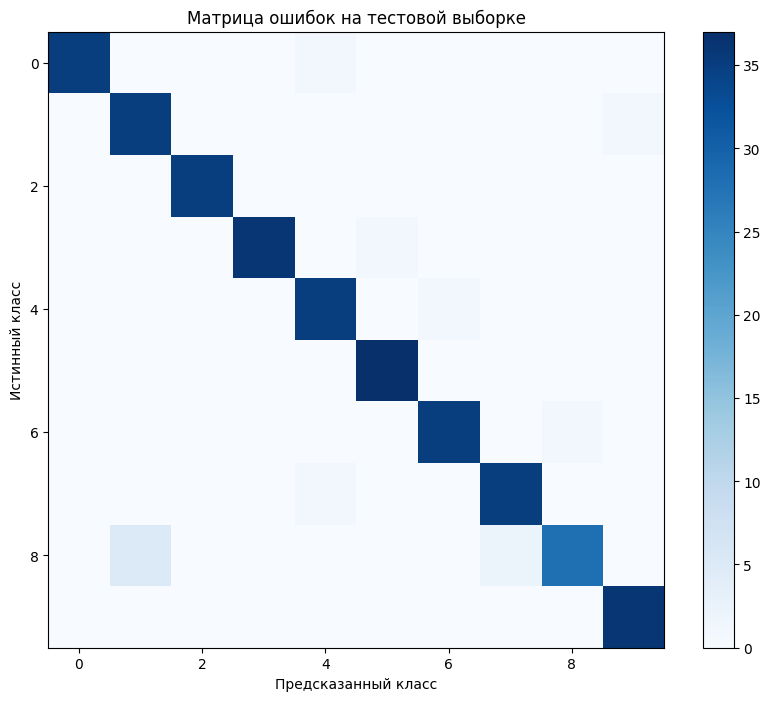

In [ ]:
device = torch.device('cpu')
model = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
val_accuracies = []

n_epochs = 30

for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader_normalized:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step() # обновление весов
        
        train_loss += loss.item()
    

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader_normalized:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            
            # Точность
            # Индекс максимального значения (предсказанная цифра)
            _, predicted = outputs.max(1)
            # Количество изображений
            total += batch_y.size(0)
            # Количество правильных предсказаний
            correct += predicted.eq(batch_y).sum().item()
    

    train_losses.append(train_loss / len(train_loader_normalized))
    val_losses.append(val_loss / len(val_loader_normalized))
    val_accuracies.append(correct / total)
    

    print(f'Epoch [{epoch+1}/{n_epochs}]')
    print(f'Train Loss: {train_losses[-1]:.4f}')
    print(f'Val Loss: {val_losses[-1]:.4f}')
    print(f'Val Accuracy: {val_accuracies[-1]:.2f}%')
    print('-' * 50)


print("\nОценка на тестовой выборке:")
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
confusion_mat = torch.zeros(10, 10)

with torch.no_grad():
    for batch_X, batch_y in test_loader_normalized:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        
        _, predicted = outputs.max(1)
        test_total += batch_y.size(0)
        test_correct += predicted.eq(batch_y).sum().item()
        
        for t, p in zip(batch_y, predicted):
            confusion_mat[t.long(), p.long()] += 1

test_accuracy = 100. * test_correct / test_total
print(f'Test accuracy: {test_accuracy:.2f}%')

# 3. Визуализация
plt.figure(figsize=(10, 8))
plt.imshow(confusion_mat, cmap='Blues')
plt.title('Confusion matrix')
plt.colorbar()
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

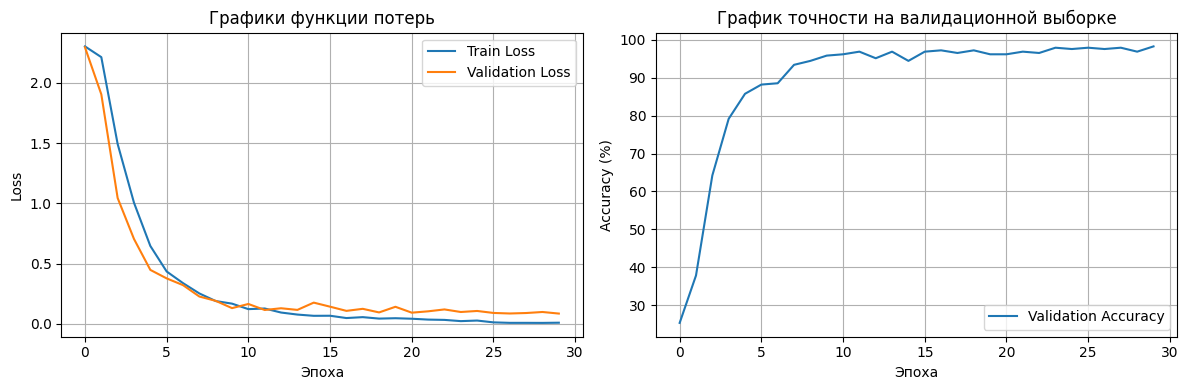

In [33]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Графики функции потерь')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.title('График точности на валидационной выборке')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()